In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, UpSampling2D
print("Tensorflow version: ", tf.__version__)
print("Number of GPU: ", len(tf.config.experimental.list_physical_devices("XLA_GPU")))
import numpy as np
import os
import time

Tensorflow version:  2.3.0
Number of GPU:  1


# VGG19

In [2]:
# VGG19 for feature extraction, using for losses calculation
vgg19Net = tf.keras.applications.VGG19(
    weights='imagenet', # Load weights pre-trained on ImageNet.
    input_shape = (256, 256,3),
    include_top=False, # Do not include the ImageNet classifier at the top
)

# Get VGG19 features

In [16]:
feature_names = ["block1_conv1", 
                 "block2_conv1",
                 "block3_conv1",
                 "block4_conv1",
                 "block5_conv1"]

features_list = []
for feture_name in feature_names:
    layer_output = vgg19Net.get_layer(feture_name).output 
    features_list.append(layer_output)

# VGG19 Model feature

In [17]:
# Create feature extraction model
model_feature = keras.Model(inputs=vgg19Net.inputs, outputs=features_list, name="vgg19featureModel")
model_feature.trainable = False

# Feature inference function

In [18]:
# Define feature inference function
def featureInference(inputs, featureModel):
    inputs = tf.reverse(inputs, [-1]) - np.array([103.939, 116.779, 123.68])
    features = featureModel(inputs)
    return features

# Gram Matrice

In [19]:
# Define Gram matrice
def gramMatrice(layer):
    layerShape = layer.shape
    batch_size = layerShape[0]
    width = layerShape[1]
    height = layerShape[2]
    num_filters = layerShape[3]
    
    filters = tf.reshape(layer, tf.stack([batch_size, -1, num_filters]))
    
    return tf.matmul(filters, filters, transpose_a=True) / tf.cast(tf.size(layer),tf.float32)

# Content loss

In [20]:
# Define Content loss function
def content_loss(content_features, target_features):
    # using 'conv4_1' to compare content and target features
    return  tf.nn.l2_loss(content_features[3] - target_features[3]) / tf.cast(tf.size(content_features[3]), dtype=tf.float32)


# Style loss

In [21]:
# Define Style loss function
def style_loss(style_features, target_features):
    styleLoss = 0
    for i in range(5): # corresponding to 5 feature layers: ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
        s_feature = style_features[i]
        s_Gram = gramMatrice(s_feature)
        
        t_feature = target_features[i]
        t_Gram = gramMatrice(t_feature)
        
        styleLoss += 0.2*tf.nn.l2_loss(s_Gram-t_Gram) / (4*tf.cast(tf.size(t_Gram), dtype=tf.float32)**2)
    return styleLoss

# Total loss

In [22]:
# Define Total loss
def total_loss(content_features, style_features,target_features, content_weight, style_weight):
    
    sLoss = style_loss(style_features, target_features)
    cLoss = content_loss(content_features, target_features)
    total_loss = sLoss * style_weight + cLoss * content_weight
    return total_loss

# Save image

In [23]:
# Save target image
def saveTargetImage(targetTensor,targetName):
    target_image_resized = tf.image.resize(targetTensor, [cHeight, cWidth], method='nearest')
    target_image_resized = target_image_resized.numpy()[0, :, :, :]
    target_image_resized = tf.keras.preprocessing.image.array_to_img(target_image_resized)

    resultPath = os.path.join(targetPath, targetName)
    
    return target_image_resized.save(resultPath)

# Training

In [24]:
import glob
import shutil
import os
import PIL
from PIL import Image
# Initialize the parameters
contentDSPath = "./image/content.jpg"
styleDSPath = "./image/style.jpg"
targetPath = "./output/"
cWidth, cHeight = Image.open(contentDSPath).convert('RGB').size
sWidth, sHeight = Image.open(styleDSPath).convert('RGB').size
IMAGE_SIZE = 256
BATCH_SIZE = 1
content_weight = 1
style_weight = 1e10
iterations = 200000
optimizer = keras.optimizers.Adam()

In [25]:
# Preprocessing content image
content_image_raw = tf.keras.preprocessing.image.load_img(contentDSPath, target_size=(IMAGE_SIZE,IMAGE_SIZE)) # target_size=(image_size,image_size) 
content_image = keras.preprocessing.image.img_to_array(content_image_raw) 
content_image = np.array([content_image])
content_image = tf.cast(content_image, tf.float32) 

# Preprocessing content image
style_image_raw = tf.keras.preprocessing.image.load_img(styleDSPath, target_size=(IMAGE_SIZE,IMAGE_SIZE)) # target_size=(image_size,image_size) 
style_image = keras.preprocessing.image.img_to_array(style_image_raw) 
style_image = np.array([style_image])
style_image = tf.cast(style_image, tf.float32)

#Initiate target image
target_image = content_image
target_image = tf.Variable(target_image,trainable=True)

# Run optimization

In [26]:
# Define Training function
@tf.function
def train_step(content_image, style_image, target_image, content_weight, style_weight):
    with tf.GradientTape() as tape:
        
        content_features = featureInference(content_image, model_feature)
        style_features   = featureInference(style_image  , model_feature)
        target_features  = featureInference(target_image , model_feature)

        loss = total_loss(content_features,
                          style_features, 
                          target_features, 
                          content_weight,
                          style_weight)

    gradients = tape.gradient(loss, target_image)

    optimizer.apply_gradients([(gradients, target_image)])
    return loss

In [27]:
# Optimization by N iterations.
start_time = time.time()
for iteration in range(iterations):
   
    loss_value = train_step(content_image, style_image, target_image, content_weight, style_weight)
    if iteration % 10000 == 0:
        targetName = 'target_' + str(iteration) + '.png'
        saveTargetImage(target_image,targetName)
        print("Iteration: %d:, Loss: %.8f" % (iteration, (float(loss_value))))

targetName = 'target_' + str(iteration) + '.png'
saveTargetImage(target_image,targetName)
print("Time taken: %.2fs" % (time.time() - start_time))

Iteration: 0:, Loss: 3194541568.00000000
Iteration: 10000:, Loss: 1774358656.00000000
Iteration: 20000:, Loss: 1000271680.00000000
Iteration: 30000:, Loss: 575056704.00000000
Iteration: 40000:, Loss: 367493216.00000000
Iteration: 50000:, Loss: 242935296.00000000
Iteration: 60000:, Loss: 163225504.00000000
Iteration: 70000:, Loss: 114097240.00000000
Iteration: 80000:, Loss: 82879560.00000000
Iteration: 90000:, Loss: 61700896.00000000
Iteration: 100000:, Loss: 46503816.00000000
Iteration: 110000:, Loss: 35167352.00000000
Iteration: 120000:, Loss: 26509040.00000000
Iteration: 130000:, Loss: 19762710.00000000
Iteration: 140000:, Loss: 14443570.00000000
Iteration: 150000:, Loss: 10324634.00000000
Iteration: 160000:, Loss: 7220005.00000000
Iteration: 170000:, Loss: 4996116.00000000
Iteration: 180000:, Loss: 3524284.50000000
Iteration: 190000:, Loss: 2622779.50000000
Time taken: 2950.07s


# Visualization

(-0.5, 719.5, 1079.5, -0.5)

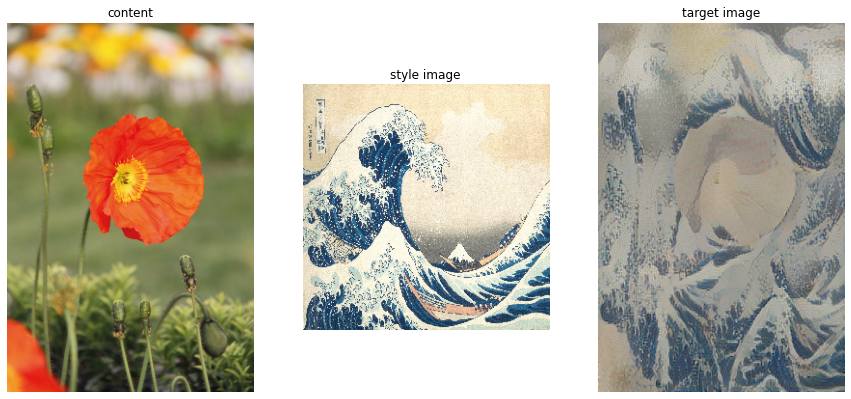

In [34]:
resultPath = os.path.join(targetPath, targetName)
target_image_visu = tf.keras.preprocessing.image.load_img(resultPath,target_size=(cHeight,cWidth))
content_image_visu = tf.keras.preprocessing.image.load_img(contentDSPath)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
ax = plt.subplot(1,3, 1)
plt.imshow(content_image_visu)
plt.title("content")
plt.axis("off")
ax = plt.subplot(1,3, 2)
plt.imshow(style_image_raw)
plt.title("style image")
plt.axis("off")
ax = plt.subplot(1,3, 3)
plt.imshow(target_image_visu)
plt.title("target image")
plt.axis("off")